In [1]:
import allel
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from collections import namedtuple
import datetime
import h5py
import ingenos
import itertools
from itertools import product
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

from matplotlib import collections as mc
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

sns.set_style("white")
os.environ["CARTOPY_USER_BACKGROUNDS"] = "/afs/crc.nd.edu/user/r/rlove1/Cartopy/BG"
%matplotlib inline

##### set base directory

In [2]:
base = "/afs/crc.nd.edu/group/BesanskyNGS/data05/comp_karyo"

##### read in metadata

In [3]:
md_2L = pd.read_csv(base + "/metadata/all_samples_2L_metadata_annotated_sites_matching_051019.csv", sep="\t")
md_2R = pd.read_csv(base + "/metadata/all_samples_2R_metadata_annotated_sites_matching_052619.csv", sep="\t")

##### add taxon column 

In [4]:
md_2R = md_2R.assign(taxon = pd.Series(md_2R["species"]).values)

md_2R["taxon"].value_counts()

An. gambiae     870
An. coluzzii    341
None            113
hybrid           22
unknown           1
Name: taxon, dtype: int64

In [5]:
md_2R["taxon"] = md_2R["taxon"].map({"An. gambiae" : "gambiae",
                    "An. coluzzii" : "coluzzii",
                   "None" : "other",
                   "hybrid" : "other",
                   "unknown" : "other"})

md_2R["taxon"].value_counts()

gambiae     870
coluzzii    341
other       136
Name: taxon, dtype: int64

In [6]:
md_2L = md_2L.assign(taxon = pd.Series(md_2L["species"]).values)

md_2L["taxon"] = md_2L["taxon"].map({"An. gambiae" : "gambiae",
                    "An. coluzzii" : "coluzzii",
                   "None" : "other",
                   "hybrid" : "other",
                   "unknown" : "other"})

md_2L["taxon"].value_counts()

gambiae     870
coluzzii    341
other       136
Name: taxon, dtype: int64

##### mark all "hybrid" specimens as other

In [7]:
md_2R.loc[((md_2R["country"] == "Guinea-Bissau") |\
           (md_2R["country"] == "Gambia, The") |\
           (md_2R["country"] == "Kenya")),"taxon"] = "other"

md_2L.loc[((md_2L["country"] == "Guinea-Bissau") |\
           (md_2L["country"] == "Gambia, The") |\
           (md_2L["country"] == "Kenya")),"taxon"] = "other"

In [8]:
##from https://gist.github.com/ihincks/6a420b599f43fcd7dbd79d56798c4e5a

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [9]:
country_list = md_2R["country"].unique()
species_list = md_2R["taxon"].unique()

In [10]:
columns = {}

for combo in list(product(country_list, species_list)):
    
    country = combo[0]
    taxon = combo[1]
    
    chunk_2R = md_2R.loc[((md_2R["country"] == country) & (md_2R["taxon"] == taxon)),:]

    if len(chunk_2R) >= 5:

        name = country + "_" + taxon.lstrip("An. ")
        
        if taxon == "coluzzii":
            columns[name] = ["2Rb_assigned","2Rc_col_assigned","2Ru_assigned"]
            
        elif taxon == "gambiae":
            
            if country == "Mali":
                columns[name] = ["2Rj_assigned","2Rb_assigned","2Rd_assigned","2Ru_assigned"]
                
            elif country == "France":
                columns[name] = ["2Rb_assigned","2Rc_gam_assigned","2Rd_assigned","2Ru_assigned"]
                
            else:
                
                columns[name] = ["2Rj_assigned","2Rb_assigned","2Rc_gam_assigned","2Rd_assigned","2Ru_assigned"]
        
        elif taxon == "other":
            
            if country == "Kenya":
                
                columns[name] = []
                
            elif country == "Gambia, The" or country == "Guinea-Bissau":
                
                columns[name] = ["2Rb_assigned"]

In [11]:
karyos_dict = {}

for combo in list(product(country_list, species_list)):
    
    country = combo[0]
    taxon = combo[1]
    
    chunk_2R = md_2R.loc[((md_2R["country"] == country) & (md_2R["taxon"] == taxon)),:]
    chunk_2L = md_2L.loc[((md_2L["country"] == country) & (md_2L["taxon"] == taxon)),:]

    if len(chunk_2R) >= 5:
        
        name = country + "_" + taxon.lstrip("An. ")
        
        karyos_dict[name] =\
            pd.DataFrame((chunk_2R[columns[name]].apply(
            pd.Series.value_counts, normalize=True)).T, columns=[0,1,2])
                
        karyos_dict[name].loc["2La_assigned"] = chunk_2L["2La_assigned"].value_counts(normalize=True)
        
        karyos_dict[name].fillna(0, inplace=True)

##### iterate and plot for each combination

In [12]:
colors_2 = {"2Rj_assigned" : "midnightblue",
           "2Rb_assigned" : "forestgreen",
            "2Rc_col_assigned" : "maroon",
           "2Rc_gam_assigned" : "maroon",
           "2Rd_assigned" : "indigo",
           "2Ru_assigned" : "darkorange",
           "2La_assigned" : "black"}

colors_1 = {inversion : lighten_color(colors_2[inversion], 0.6) for inversion in colors_2.keys()}

colors_0 = {inversion : lighten_color(colors_2[inversion], 0.2) for inversion in colors_2.keys()}

In [13]:
colors_1

{'2Rj_assigned': (0.2825075139544868, 0.2825075139544868, 0.8398454272219837),
 '2Rb_assigned': (0.3628969738184291, 0.8441618497109826, 0.3628969738184291),
 '2Rc_col_assigned': (1.0, 0.1011764705882352, 0.1011764705882352),
 '2Rc_gam_assigned': (1.0, 0.1011764705882352, 0.1011764705882352),
 '2Rd_assigned': (0.621719457013574, 0.10588235294117654, 1.0),
 '2Ru_assigned': (1.0, 0.7294117647058823, 0.3999999999999999),
 '2La_assigned': (0.4, 0.4, 0.4)}

In [14]:
colors_0

{'2Rj_assigned': (0.760835837984829, 0.760835837984829, 0.9466151424073279),
 '2Rb_assigned': (0.787632324606143, 0.9480539499036609, 0.787632324606143),
 '2Rc_col_assigned': (0.9999999999999999,
  0.7003921568627453,
  0.7003921568627453),
 '2Rc_gam_assigned': (0.9999999999999999,
  0.7003921568627453,
  0.7003921568627453),
 '2Rd_assigned': (0.8739064856711913, 0.7019607843137254, 1.0),
 '2Ru_assigned': (0.9999999999999999, 0.9098039215686274, 0.8000000000000002),
 '2La_assigned': (0.8, 0.8, 0.8)}

##### set GPS coords for each combination of country and taxon.

##### read in the version of the metadata file with lat and long

In [15]:
has_ll = pd.read_csv(base + "/metadata/original_phase2_metadata.txt", sep="\t")
#NB this file was downloaded directly from: ftp://ngs.sanger.ac.uk/production/ag1000g/phase2/AR1/samples/samples.meta.txt
#and renamed

In [16]:
has_ll = has_ll[["ox_code","latitude","longitude"]]

In [17]:
has_ll.head()

,ox_code,latitude,longitude
0,AA0040-C,5.60858,-1.54926
1,AA0041-C,5.60858,-1.54926
2,AA0042-C,4.91217,-1.77397
3,AA0043-C,4.91217,-1.77397
4,AA0044-C,4.91217,-1.77397


In [18]:
md_2R_ll = pd.merge(md_2R, has_ll, left_on = "ox_code", right_on = "ox_code", how="outer")

In [19]:
md_2R_ll.loc[md_2R_ll["latitude"].isnull(),"GPS"].str.replace(",",";").str.split(";", expand=True).head()

,0,1
1142,9.78445327,13.8640676
1143,9.51335958867261,13.8229987622174
1144,5.479337225,10.45698257
1145,5.479337225,10.45698257
1146,None,None


In [20]:
md_2R_ll.loc[md_2R_ll["latitude"].isnull(),"GPS"].str.replace(",",";").str.split(";", expand=True)[0].values

array(['9.78445327', '9.51335958867261', '5.479337225', '5.479337225',
       'None', '10.46198367', '9.437679268', '9.4242750027745',
       '8.88782631941682', '8.660388177', '8.5335969', '8.52469274436943',
       '8.39403840905392', '8.097801288', '10.52209142', '3.51636323',
       '12.1', '12.1', '12.1', '12.1', '12.1', '12.1', '12.1', '12.1',
       '12.1', '12.1', '12.1', '12.1', '12.1', '12.1', '12.1', '12.1',
       '12.1', '12.1', '12.1', '12.1', '10.42549826', '10.34163244',
       '10.30048088', '10.25642189', '10.21098056', '10.18821826',
       '10.18821826', '10.18821826', '10.18821826', '10.1022691325695',
       '10.04954206', '4.332449785', '3.51636323', '4.165824304',
       '3.869744764', '3.804898362', '3.804898362', '3.804898362',
       '3.804898362', '5.479337225', '10.42549826', '10.42549826',
       '4.332449785', '4.332449785', '4.332449785', '10.18821826',
       '10.70845919', '10.6581823', '10.49549937', '10.49549937',
       '10.46198367', '10.42549826',

In [21]:
md_2R_ll.loc[md_2R_ll["latitude"].isnull(),"latitude"] =\
md_2R_ll.loc[md_2R_ll["latitude"].isnull(),"GPS"].str.replace(",",";").str.split(";", expand=True)[0]

md_2R_ll.loc[md_2R_ll["longitude"].isnull(),"longitude"] =\
md_2R_ll.loc[md_2R_ll["longitude"].isnull(),"GPS"].str.replace(",",";").str.split(";", expand=True)[1]

In [22]:
md_2R_ll["latitude"].fillna("None", inplace=True)
md_2R_ll["longitude"].fillna("None", inplace=True)

##### now, get the mean for each set of species/country in karyo_dict

In [23]:
lat_long_dict = {}

for name in karyos_dict.keys():
    
    country = name.split("_")[0]
    taxon = name.split("_")[1]
    
    chunk = md_2R_ll.loc[((md_2R_ll["country"] == country) & (md_2R_ll["taxon"] == taxon))]
        
    lat = chunk.loc[chunk["latitude"] != "None","latitude"].map(float).mean()
    long = chunk.loc[chunk["longitude"] != "None","longitude"].map(float).mean()
    
    lat_long_dict[name] = (lat,long)

In [24]:
lat_long_dict

{'Ghana_coluzzii': (5.377246000000001, -1.317371090909091),
 'Ghana_gambiae': (5.668489999999999, -0.21928000000000006),
 'Burkina Faso_coluzzii': (11.297500000000003, -4.1901016260162605),
 'Burkina Faso_gambiae': (11.296826923076923, -4.015),
 'Uganda_gambiae': (0.7699999999999998, 34.026),
 'Gambia, The_other': (13.549999999999999, -15.900000000000004),
 'Guinea-Bissau_other': (11.914893813186813, -15.606377208791208),
 'Kenya_other': (-3.7106666666666666, 39.82033333333333),
 'Cameroon_coluzzii': (4.625118550111111, 11.833181038888888),
 'Cameroon_gambiae': (5.7602645569893225, 13.815448812297216),
 'France_gambiae': (-12.865479250000002, 45.136409500000006),
 'Equatorial Guinea_gambiae': (3.7000000000000006, 8.7),
 'Angola_coluzzii': (-8.821000000000002, 13.291),
 'Gabon_gambiae': (0.384, 9.455000000000004),
 'Guinea_gambiae': (8.903846153846153, -9.686230769230765),
 "Cote d'Ivoire_coluzzii": (5.898390000000001, -4.822929999999999),
 'Mali_coluzzii': (13.169912276315786, -6.67508

In [25]:
np.min([lat_long_dict[name][0] for name in lat_long_dict.keys()])

-12.865479250000002

In [26]:
np.max([lat_long_dict[name][0] for name in lat_long_dict.keys()])

13.549999999999999

In [27]:
np.min([lat_long_dict[name][1] for name in lat_long_dict.keys()])

-15.900000000000004

In [28]:
np.max([lat_long_dict[name][1] for name in lat_long_dict.keys()])

45.136409500000006

##### manually adjust plot positions

In [29]:
lat_long_dict

{'Ghana_coluzzii': (5.377246000000001, -1.317371090909091),
 'Ghana_gambiae': (5.668489999999999, -0.21928000000000006),
 'Burkina Faso_coluzzii': (11.297500000000003, -4.1901016260162605),
 'Burkina Faso_gambiae': (11.296826923076923, -4.015),
 'Uganda_gambiae': (0.7699999999999998, 34.026),
 'Gambia, The_other': (13.549999999999999, -15.900000000000004),
 'Guinea-Bissau_other': (11.914893813186813, -15.606377208791208),
 'Kenya_other': (-3.7106666666666666, 39.82033333333333),
 'Cameroon_coluzzii': (4.625118550111111, 11.833181038888888),
 'Cameroon_gambiae': (5.7602645569893225, 13.815448812297216),
 'France_gambiae': (-12.865479250000002, 45.136409500000006),
 'Equatorial Guinea_gambiae': (3.7000000000000006, 8.7),
 'Angola_coluzzii': (-8.821000000000002, 13.291),
 'Gabon_gambiae': (0.384, 9.455000000000004),
 'Guinea_gambiae': (8.903846153846153, -9.686230769230765),
 "Cote d'Ivoire_coluzzii": (5.898390000000001, -4.822929999999999),
 'Mali_coluzzii': (13.169912276315786, -6.67508

In [30]:
plot_dict = dict(lat_long_dict)

In [31]:
legend_dict = {"2Rj" : (40.1, 17.75),
              "2Rb" : (40.1, 16),
              "2Rc" : (40.1, 14.25),
              "2Rd" : (40.1, 12.5),
              "2Ru" : (40.1, 10.75),
              "2La" : (40.1, 9)}

In [32]:
plot_dict["Ghana_coluzzii"] = (-12, -5)
plot_dict["Ghana_gambiae"] = (-5, 0)
plot_dict["Burkina Faso_coluzzii"] =  (4, 2)
plot_dict["Burkina Faso_gambiae"] = (12.5, 8)
plot_dict["Uganda_gambiae"] = (0, 38)
plot_dict["Gambia, The_other"] = (10, -19)
plot_dict["Guinea-Bissau_other"] = (4, -15.6)
plot_dict["Kenya_other"] = (-8, 35)
plot_dict["Cameroon_coluzzii"] = (10, 16)
plot_dict["Cameroon_gambiae"] = (7, 24)
plot_dict["France_gambiae"] = (-14, 38)
plot_dict["Equatorial Guinea_gambiae"] = (-3.5, 12)
plot_dict["Angola_coluzzii"] = (-14, 15)
plot_dict["Gabon_gambiae"] = (-13, 5)
plot_dict["Guinea_gambiae"] = (-8, -19)
plot_dict["Cote d'Ivoire_coluzzii"] = (-14.5, -11.5)
plot_dict["Mali_coluzzii"] = (12.5, -5)
plot_dict["Mali_gambiae"] = (12.5, -13)

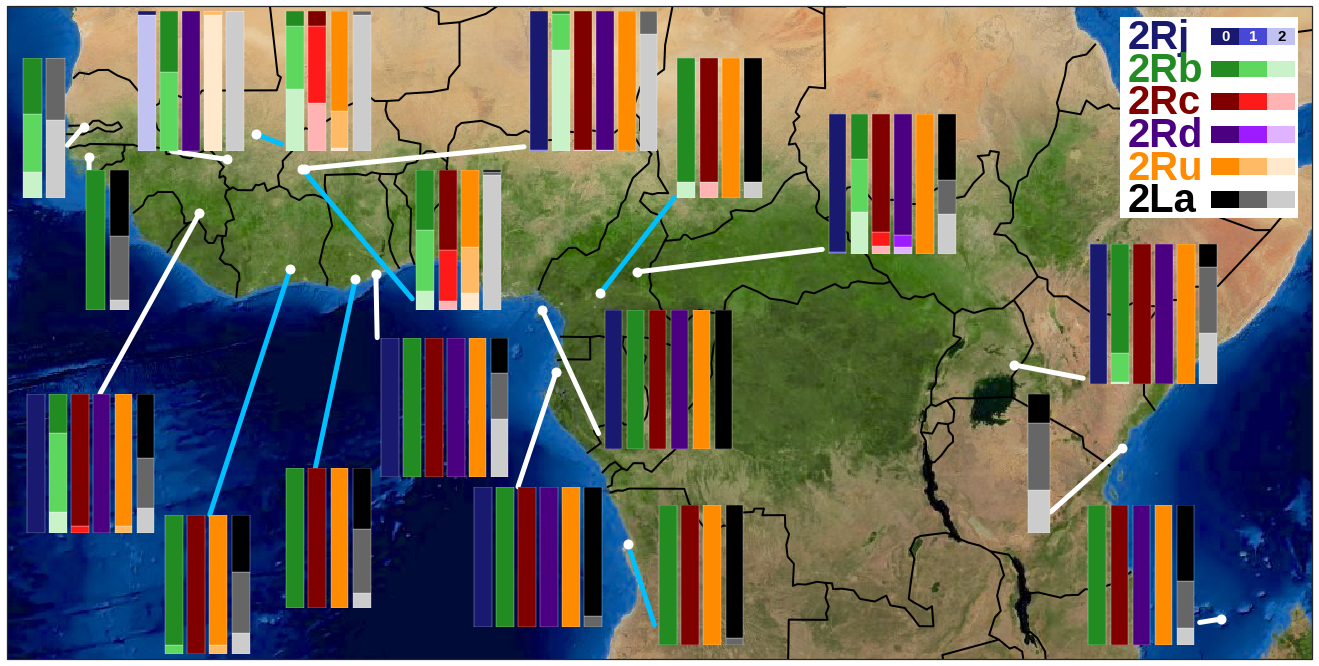

In [33]:
fig = plt.figure(figsize=(26,12))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.background_img(name='BM', resolution="high")
ax.add_feature(cfeature.BORDERS, linewidth=2)
#ax.gridlines(draw_labels=True)

ax.set_xlim(-20,50)
ax.set_ylim(-15,20)
    
for name in karyos_dict.keys():
    
    ##add the inset graph
    lat = plot_dict[name][0]
    
    long = plot_dict[name][1]
        
    chunk = karyos_dict[name]
    
    n = len(chunk)
        
    a = inset_axes(ax, width="100%", height="100%",
                   bbox_to_anchor=(long, lat, 7.5 * (n/6), 7.5), bbox_transform=ax.transData)
   
    color_list_0 = [colors_2[inversion] for inversion in chunk.index]
    color_list_1 = [colors_1[inversion] for inversion in chunk.index]
    color_list_2 = [colors_0[inversion] for inversion in chunk.index]

    a.bar(x=np.arange(n), height=chunk[2], width=0.8, color = color_list_2, edgecolor="white")
    a.bar(x=np.arange(n), height=chunk[1], width=0.8, bottom=chunk[2], color = color_list_1,
         edgecolor="white")
    a.bar(x=np.arange(n), height=chunk[0], width=0.8, bottom=(chunk[2] + chunk[1]), 
           color = color_list_0, edgecolor="white")
    
    a.set_xticklabels([])
    a.set_yticklabels([])

    a.set_ylim(0,1)
    
    a.axis("off")
    
    spot = (lat_long_dict[name][1], lat_long_dict[name][0])
    
    if name.split("_")[1] == "coluzzii": 
        
        species_color = "deepskyblue"
        
    else:
        
        species_color = "white"
        
    con = mpatches.ConnectionPatch(spot, (long, lat), "data", "data", ax, ax, 
                                       patchB = a, color=species_color, linewidth=5)
    
    ax.add_artist(con)
    
    ax.plot(spot[0], spot[1], marker = ".", 
            color="white", markersize=20, linestyle = " ", transform = ax.transData)

legend_bg = inset_axes(ax, width="100%", height="100%",
                   bbox_to_anchor=(40, 8.9, 9.5, 10.8), bbox_transform=ax.transData)
legend_bg.set_xticklabels([])
legend_bg.set_yticklabels([])
legend_bg.spines['right'].set_visible(False)
legend_bg.spines['top'].set_visible(False)
legend_bg.spines['bottom'].set_visible(False)
legend_bg.spines['left'].set_visible(False)

for inversion in legend_dict:
    
    (x,y) = legend_dict[inversion]
    
    if inversion == "2Rc":
        
        color_name = "2Rc_col_assigned"
        
    else:
    
        color_name = inversion + "_assigned"
        
    plt.text(x, y, inversion, color=colors_2[color_name], size=40, fontweight="bold", transform = ax.transData)
    
    bar0 = mpatches.Rectangle((x+4.5,y+.2),1.5,.9,linewidth=1,edgecolor='none',facecolor=colors_2[color_name], 
                              transform=ax.transData)
    bar1 = mpatches.Rectangle((x+6,y+.2),1.5,.9,linewidth=1,edgecolor='none',facecolor=colors_1[color_name], 
                              transform=ax.transData)
    bar2 = mpatches.Rectangle((x+7.5,y+.2),1.5,.9,linewidth=1,edgecolor='none',facecolor=colors_0[color_name], 
                              transform=ax.transData)
    
    for bar in [bar0, bar1, bar2]:
        
        legend_bg.add_patch(bar)
        
plt.text(legend_dict["2Rj"][0]+(4.5 + 1.5/2 - .2), legend_dict["2Rj"][1]+(.9/2), "0", color="white", size=15, 
         fontweight="bold", transform=ax.transData)
plt.text(legend_dict["2Rj"][0]+(6 + 1.5/2 - .2), legend_dict["2Rj"][1]+(.9/2), "1", color="white", size=15, 
         fontweight="bold", transform=ax.transData)
plt.text(legend_dict["2Rj"][0]+(7.5 + 1.5/2 - .2), legend_dict["2Rj"][1]+(.9/2), "2", color="black", size=15, 
         fontweight="bold", transform=ax.transData);
        
plt.savefig(ingenos.make_date_stamp(base + "/data/results/karyotypes_on_map_prototype"));